# Bra detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [59]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img , img_to_array

import pandas as pd 
import numpy as np

import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential , Model , load_model

from tensorflow.keras.utils import to_categorical

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
def extract_label(img_path, flag):
    filename, extension = os.path.splitext(os.path.basename(img_path))
    
    subject_id, etc = filename.split("__") # 2 underscore
    bra = "without_bra"
    
    if flag:
        breast_size, waist_size, band_size, cup_size, with_bra = etc.split('_')
        
        if with_bra == 'true':
            bra = "with_bra"

        return bra
    else:
        breast_size, waist_size, band_size, cup_size = etc.split('_')
        return bra

In [24]:
bra_path = "/content/drive/MyDrive/datasets/dataset/with_bra"
without_bra_path = "/content/drive/MyDrive/datasets/dataset/without_bra"

img_size = 224

images = []
labels = []

In [25]:
for image in os.listdir(bra_path):
    img = cv2.imread(os.path.join(bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(bra_path, image), True)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);


In [26]:
for image in os.listdir(without_bra_path):
    img = cv2.imread(os.path.join(without_bra_path, image), cv2.IMREAD_COLOR)
    
    img_resize = cv2.resize(img, (img_size, img_size))
        
    # flag = 0 -> no bra
    # flag = 1 -> has bra
    label = extract_label(os.path.join(without_bra_path, image), False)
    
#     print(label)
    
    labels.append(label)
    images.append(img_resize);

In [ ]:
unique_labels = unique_list = list(set(labels))

# Performing one-hot encoding on labels

In [27]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Convert image arry to np array

In [28]:
np_images = np.array(images).astype('float32')
np_labels = np.array(labels).astype('float32')

In [29]:
print(np_images.shape)
print(np_labels.shape)

unique_labels = np.asarray(unique_labels)

(530, 224, 224, 3)
(530, 2)


In [30]:
X_train, X_val, y_train, y_val = train_test_split(np_images, np_labels, test_size = 0.3, random_state = 1)

In [31]:
img_gen = ImageDataGenerator(rotation_range=40,
                            zoom_range=0.20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")

print("Train size: ",len(X_train),"Test size: ",len(X_val))

Train size:  371 Test size:  159


In [32]:
# debug 
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## MobileNetV2 acrchitecture

In [33]:
model = Sequential()
model.add(Conv2D(512,(2,2),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(256,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(128,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(64,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

model.add(Conv2D(32,(2,2),padding="same",activation="relu"))
model.add(MaxPooling2D((2,2),strides=2))

#model.add(BatchNormalization())

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(2,activation="softmax"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 512)     6656      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 512)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 256)     524544    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       131200    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

In [40]:
history = model.fit(
    X_train,
    y_train,
    epochs = 32,
    steps_per_epoch=32,
    batch_size = 10,
    validation_data = (X_val, y_val), 
    validation_steps=5,
    validation_split=0.15
)

# history = model.fit(img_gen.flow(X_train,y_train,batch_size=5),
#                     steps_per_epoch=64,
#                     validation_data=(X_val,y_val),
#                     validation_steps=300,
#                     epochs=45)

Epoch 1/32
32/32 [==============================] - 14s 446ms/step - loss: 0.0459 - accuracy: 0.9873 - val_loss: 0.5027 - val_accuracy: 0.9600
Epoch 2/32
32/32 [==============================] - 14s 443ms/step - loss: 0.0448 - accuracy: 0.9810 - val_loss: 0.4117 - val_accuracy: 0.9600
Epoch 3/32
32/32 [==============================] - 14s 445ms/step - loss: 0.0270 - accuracy: 0.9873 - val_loss: 0.4236 - val_accuracy: 0.9600
Epoch 4/32
32/32 [==============================] - 14s 443ms/step - loss: 0.0365 - accuracy: 0.9905 - val_loss: 0.3719 - val_accuracy: 0.9000
Epoch 5/32
32/32 [==============================] - 14s 444ms/step - loss: 0.0816 - accuracy: 0.9746 - val_loss: 0.4514 - val_accuracy: 0.9400
Epoch 6/32
32/32 [==============================] - 14s 442ms/step - loss: 0.0293 - accuracy: 0.9937 - val_loss: 1.0411 - val_accuracy: 0.9600
Epoch 7/32
32/32 [==============================] - 14s 444ms/step - loss: 0.1370 - accuracy: 0.9714 - val_loss: 0.8937 - val_accuracy: 0.8600

In [41]:
def plot_graph(history,string):
    plt.figure(figsize=(16,7))
    plt.plot(history.history[string],label=str(string))
    plt.plot(history.history["val_"+str(string)],label=str(string))
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()

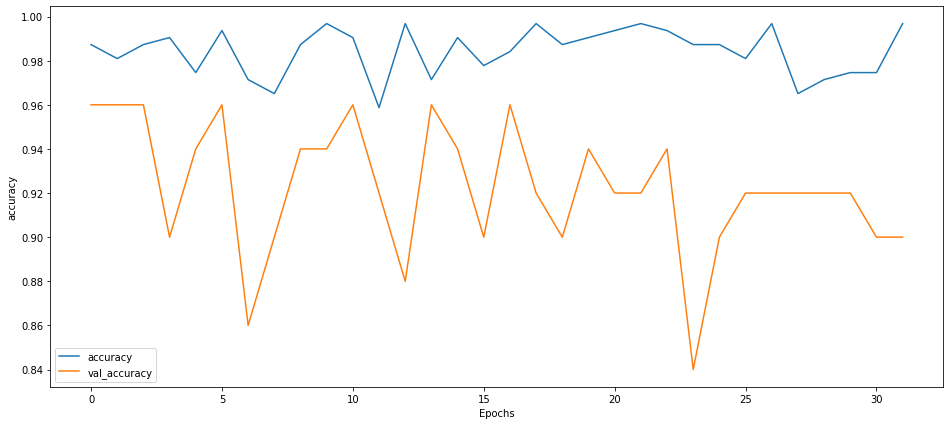

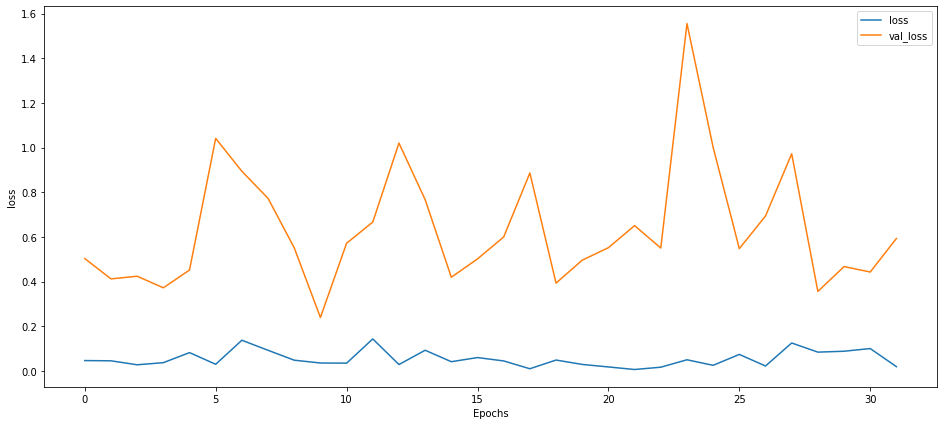

In [42]:
plot_graph(history,"accuracy")
plot_graph(history,"loss")

## Save model

In [46]:
model.save('/content/drive/MyDrive/datasets/dataset/bra_dection_mobileNetV2_improvised.h5')

## Test Result 

In [47]:
pred = model.predict(X_val)

In [48]:
print(pred[1])
print(y_val[10])

[3.0592783e-23 1.0000000e+00]
[0. 1.]


# Preprocess test images


In [ ]:
def load_image(image_path):
    return tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=[INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE]
    )

In [ ]:
def image_to_array(image):
    return tf.keras.preprocessing.image.img_to_array(image, dtype=np.int32)

In [ ]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [ ]:
test_images = []

for image_path in TEST_IMAGE_PATHS:
    # <PIL.Image.Image image mode=RGB size=224x224 at 0x141247ED0>
    test_image = load_image(image_path)
    test_image_array = image_to_array(test_image)

In [ ]:
print(test_images[1])

In [ ]:
def image_preprocess(image_array):
    return tf.keras.applications.mobilenet_v2.preprocess_input(
        image_array[tf.newaxis, ...]
    )

In [ ]:
test_images_preprocessed = []

for test_image in test_images:
    test_image_preprocessed = image_preprocess(test_image)
    test_images_preprocessed.append(test_image_preprocessed)

In [ ]:
print('Image shape before preprocessing:', test_images[0].shape)
print('Image shape after preprocessing:', test_images_preprocessed[0].shape)

In [ ]:
def get_tags(probs, labels, max_classes = 2, prob_threshold = 0.01):
    probs_mask = probs > prob_threshold
    probs_filtered = probs[probs_mask] * 100
    labels_filtered = unique_labels[probs_mask]
    
    sorted_index = np.flip(np.argsort(probs_filtered))
    labels_filtered = labels_filtered[sorted_index][:max_classes]
    probs_filtered = probs_filtered[sorted_index][:max_classes].astype(np.int)
    
    tags = ''
    for i in range(0, len(labels_filtered)):
        tags = tags + labels_filtered[i] + ' (' + str(probs_filtered[i]) + '%), ' 

    return tags, labels_filtered, probs_filtered 

In [ ]:
TEST_IMAGE_INDEX = 1

In [ ]:
result = model(test_images_preprocessed[TEST_IMAGE_INDEX])

In [ ]:
print(result)

In [ ]:
np_result = result.numpy()[0]

In [ ]:
print(np_result)

In [ ]:
tags, labels_filtered, probs_filtered = get_tags(np_result, unique_labels)

In [ ]:
print('probs_filtered:', probs_filtered)
print('labels_filtered:', labels_filtered)

In [ ]:
plt.figure()
plt.title(tags)
plt.imshow(test_image);

plt.show()